# Vibration of a beam clamped at one end
The beam is increasingly loaded at its other end, and then suddenly released.

- Time-domain, implicit scheme
- 3D
- Rayleigh damping

This example is adapted from (legacy Fenics):  
&emsp; https://comet-fenics.readthedocs.io/en/latest/demo/elastodynamics/demo_elastodynamics.py.html  
where extensive explanations are given. Here we show how `elastodynamicsx` can be used to reproduce it.

In [1]:
import numpy as np

from dolfinx import mesh, fem, default_scalar_type
from mpi4py import MPI

from elastodynamicsx.pde import material, boundarycondition, PDE, damping
from elastodynamicsx.solvers import TimeStepper
from elastodynamicsx.utils import make_facet_tags, ParallelEvaluator

### FE domain

In [2]:
L_, B_, H_ = 1, 0.04, 0.1
Nx, Ny, Nz = 60, 5, 10  # Nb of elts.

extent = [[0., 0., 0.], [L_, B_, H_]]

# create the mesh
domain = mesh.create_box(MPI.COMM_WORLD, extent, [Nx, Ny, Nz])

# create the function space
V = fem.FunctionSpace(domain, ("Lagrange", 1, (domain.geometry.dim,)))

# define some tags
tag_left, tag_top, tag_right, tag_bottom, tag_back, tag_front = 1, 2, 3, 4, 5, 6
boundaries = [(tag_left  , lambda x: np.isclose(x[0], 0.)),
              (tag_right , lambda x: np.isclose(x[0], L_)),
              (tag_bottom, lambda x: np.isclose(x[1], 0.)),
              (tag_top   , lambda x: np.isclose(x[1], B_)),
              (tag_back  , lambda x: np.isclose(x[2], 0.)),
              (tag_front , lambda x: np.isclose(x[2], H_))]

facet_tags = make_facet_tags(domain, boundaries)

### Boundary conditions
- Clamp the left face
- Apply a load on the right face

In [3]:
# Left: clamp
bc_l = boundarycondition((V, facet_tags, tag_left), 'Clamp')

# Right: normal traction (Neumann boundary condition)
T_N  = fem.Constant(domain, np.array([0] * 3, dtype=default_scalar_type))
bc_r = boundarycondition((V, facet_tags, tag_right), 'Neumann', T_N)

bcs  = [bc_l, bc_r]  # list all BCs

Define the temporal behavior of the source

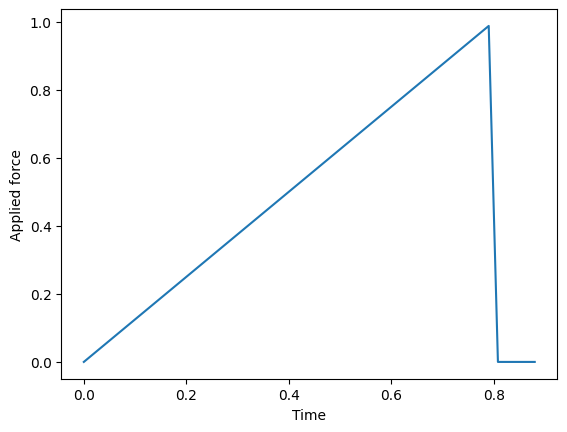

In [4]:
# -> Time function
p_0 = 1.  # max amplitude
F_0 = p_0 * np.array([0, 0, 1], dtype=default_scalar_type)  # source orientation
cutoff_Tc = 4 / 5  # release time

src_t        = lambda t: t / cutoff_Tc * (t > 0) * (t <= cutoff_Tc)
T_N_function = lambda t: src_t(t) * F_0

if domain.comm.rank == 0:
    import matplotlib.pyplot as plt
    t = np.linspace(0, 1.1 * cutoff_Tc)
    plt.plot(t, src_t(t))
    plt.xlabel('Time')
    plt.ylabel('Applied force')
    plt.show()

### Define the material law
- isotropic elasticity
- with Rayleigh damping: $[C] = \eta_M [M] + \eta_K [K]$ where $[M]$, $[K]$ and $[C]$ are the mass, stiffness and damping matrices

In [5]:
# Parameters here...
E, nu = 1000, 0.3  # Young's modulus and Poisson's ratio
rho = 1  # mass density

eta_m = 0.01  # Rayleigh damping param
eta_k = 0.01  # Rayleigh damping param
# ... end

# Convert Young & Poisson to Lamé's constants
lambda_ = E * nu / (1 + nu) / (1 - 2 * nu)
mu      = E / 2 / (1 + nu)

# Convert floats to fem.Constant
rho     = fem.Constant(domain, default_scalar_type(rho))
lambda_ = fem.Constant(domain, default_scalar_type(lambda_))
mu      = fem.Constant(domain, default_scalar_type(mu))
eta_m = fem.Constant(domain, default_scalar_type(eta_m))
eta_k = fem.Constant(domain, default_scalar_type(eta_k))

material = material(V,
                    'isotropic',
                    rho, lambda_, mu,
                    damping=damping('Rayleigh', eta_m, eta_k))

### Assemble the PDE

In [6]:
pde = PDE(V, materials=[material], bodyforces=[], bcs=bcs)

### Time scheme
We use the Generalized-alpha method, which is an explicit scheme that can be viewed as an extention of the Newmark-$\beta$ family. The parameters of the scheme are $\alpha_m$, $\alpha_f$, $\gamma$, $\beta$. Here we take:
- $\alpha_m=0.2$,
- $\alpha_f=0.4$,

while the other parameters are set by default to $\gamma=\frac{1}{2} + \alpha_f - \alpha_m$ and $\beta = \frac{1}{4}(\gamma + \frac{1}{2})^2$ to ensure second order accuracy, and stability. Note that stability is only unconditionnal in the linear, non dissipative case.

See:  
&emsp;J. Chung and G. M. Hulbert, *A time integration algorithm for structural dynamics with improved numerical dissipation: The generalized-α method*,J. Appl. Mech. 60(2), 371–375 (1993).

In [7]:
# Temporal parameters
T      = 4  # duration; difference with original example: here t=[0,T-dt]
Nsteps = 50  # number of time steps
dt = T / Nsteps  # time increment

# Generalized-alpha method parameters
alpha_m = 0.2
alpha_f = 0.4
kwargsTScheme = dict(scheme='g-a-newmark', alpha_m=alpha_m, alpha_f=alpha_f)

# Time integration: define a TimeStepper instance
tStepper = TimeStepper.build(V, pde.m, pde.c, pde.k, pde.L, dt, bcs=bcs, **kwargsTScheme)

# Set the initial values
tStepper.set_initial_condition(u0=[0, 0, 0], v0=[0, 0, 0], t0=0)

### Define outputs
- Extract signals at few points
- Compute the kinetic, elastic and damping energies
- Live-plot results (only in a terminal; not in a notebook)

In [8]:
# -> Point evaluation
# Define points
points_out = np.array([[L_, B_ / 2, 0]]).T

# Declare a convenience ParallelEvaluator
paraEval = ParallelEvaluator(domain, points_out)

# Declare data (local process)
signals_local = np.zeros((paraEval.nb_points_local,
                          V.num_sub_spaces,
                          Nsteps))  # <- output stored here

# -> Energies
energies = np.zeros((Nsteps, 4))
E_damp = 0  # declare; init value

u_n = tStepper.timescheme.u  # The displacement at time t_n
v_n = tStepper.timescheme.v  # The velocity at time t_n
comm = V.mesh.comm
Energy_elastic = lambda *a: comm.allreduce(fem.assemble_scalar(fem.form(1/2 * pde.k(u_n, u_n))), op=MPI.SUM)
Energy_kinetic = lambda *a: comm.allreduce(fem.assemble_scalar(fem.form(1/2 * pde.m(v_n, v_n))), op=MPI.SUM)
Energy_damping = lambda *a: dt * comm.allreduce(fem.assemble_scalar(fem.form(pde.c(v_n, v_n))), op=MPI.SUM)

# -> live plotting parameters
clim = 0.4 * L_ * B_ * H_ / (E * B_ * H_**3 / 12) * np.amax(F_0) * np.array([0, 1])
live_plotter = {'refresh_step': 1, 'clim': clim, 'window_size': [640, 480]} if domain.comm.rank == 0 else None


# -> Define callbacks: will be called at the end of each iteration
def cbck_storeAtPoints(i, out):
    if paraEval.nb_points_local > 0:
        signals_local[:, :, i+1] = u_n.eval(paraEval.points_local, paraEval.cells_local)


def cbck_energies(i, out):
    global E_damp
    E_elas = Energy_elastic()
    E_kin  = Energy_kinetic()
    E_damp+= Energy_damping()
    E_tot  = E_elas + E_kin + E_damp
    energies[i+1, :] = np.array([E_elas, E_kin, E_damp, E_tot])

### Solve
- Define a 'callfirst' function to update the load BC
- Run the time loop

In [9]:
# 'callfirsts': will be called at the beginning of each iteration
def cfst_updateSources(t):
    T_N.value = T_N_function(t)


# Run the big time loop!
tStepper.solve(Nsteps - 1,
               callfirsts=[cfst_updateSources],
               callbacks=[cbck_storeAtPoints, cbck_energies],
               live_plotter=live_plotter)
# End of big calc.

  0%|          | 0/49 [00:00<?, ?it/s]

### Post-processing
Plot tip displacement and energies evolution

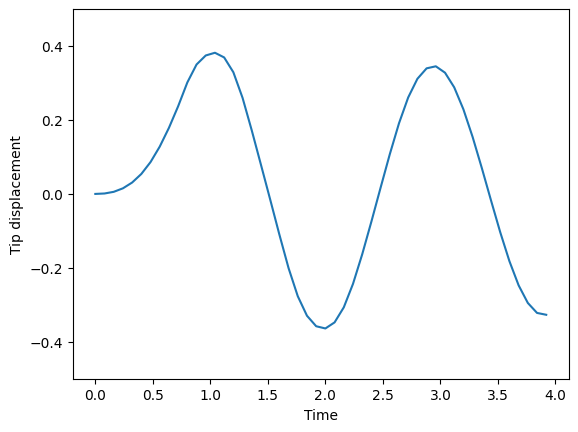

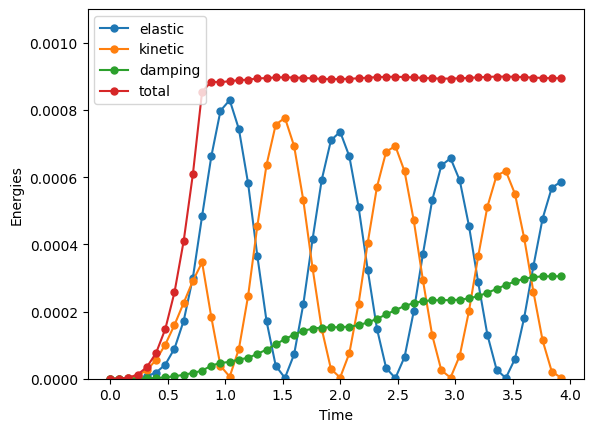

In [10]:
# Gather the data to the root process
all_signals = paraEval.gather(signals_local, root=0)

# Plot only on rank == 0
if domain.comm.rank == 0:
    t = dt * np.arange(energies.shape[0])

    # Tip displacement
    u_tip = all_signals[0]
    plt.figure()
    plt.plot(t, u_tip[2, :])
    plt.xlabel('Time')
    plt.ylabel('Tip displacement')
    plt.ylim(-0.5, 0.5)

    # Energies
    plt.figure()
    plt.plot(t, energies, marker='o', ms=5)
    plt.legend(("elastic", "kinetic", "damping", "total"))
    plt.xlabel("Time")
    plt.ylabel("Energies")
    plt.ylim(0, 0.0011)
    plt.show()